In [121]:
%reload_ext autoreload
%autoreload 2

import requests
import matplotlib.pyplot as plt
import json
import csv
import os
import pandas as pd
import numpy as np

import fundamentalanalysis as fa
import yfinance as yf
from yahoofinancials import YahooFinancials
from fmp_python.fmp import FMP
from fmp_api_python.fmp import FMPClient

#from verstack import PandasOptimizer
#from verstack import NaNImputer
from pypots.imputation import SAITS
from xgbimputer import XGBImputer

import math
from scipy.stats import norm

import nest_asyncio
from aiohttp import ClientSession
import aiofiles
import aiohttp
import asyncio

from tqdm import tqdm

from scipy import signal
from skimage.restoration import (denoise_wavelet, estimate_sigma)

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer





# VIX Data

In [2]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

vix=pd.read_csv('raw_data/VIX_History.csv')

vix

,DATE,OPEN,HIGH,LOW,CLOSE
0,01/02/1990,17.24,17.24,17.24,17.24
1,01/03/1990,18.19,18.19,18.19,18.19
2,01/04/1990,19.22,19.22,19.22,19.22
3,01/05/1990,20.11,20.11,20.11,20.11
4,01/08/1990,20.26,20.26,20.26,20.26
...,...,...,...,...,...
8332,01/25/2023,19.56,20.90,18.99,19.08
8333,01/26/2023,19.05,19.48,18.67,18.73
8334,01/27/2023,18.90,19.00,17.97,18.51
8335,01/30/2023,19.76,20.25,19.54,19.94


# JGB Yield Curves

In [5]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

japan_curves=pd.read_csv('raw_data/Yield Curves/jgbcme_all.csv')


In [6]:
japan_curves

,Interest Rate,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,(Unit : %)
0,Date,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,25Y,30Y,40Y
1,1974/9/24,10.327,9.362,8.83,8.515,8.348,8.29,8.24,8.121,8.127,-,-,-,-,-,-
2,1974/9/25,10.333,9.364,8.831,8.516,8.348,8.29,8.24,8.121,8.127,-,-,-,-,-,-
3,1974/9/26,10.34,9.366,8.832,8.516,8.348,8.29,8.24,8.122,8.128,-,-,-,-,-,-
4,1974/9/27,10.347,9.367,8.833,8.517,8.349,8.29,8.24,8.122,8.128,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12410,2023/1/25,-0.045,-0.01,0.004,0.083,0.189,0.257,0.317,0.424,0.415,0.457,1.001,1.299,1.464,1.535,1.69
12411,2023/1/26,-0.055,-0.009,0.006,0.083,0.189,0.252,0.311,0.429,0.432,0.483,1.021,1.313,1.47,1.526,1.671
12412,2023/1/27,-0.055,0.001,0.014,0.095,0.2,0.283,0.364,0.485,0.51,0.497,1.087,1.377,1.518,1.574,1.697
12413,2023/1/30,-0.055,-0.004,0.011,0.087,0.187,0.273,0.361,0.472,0.493,0.497,1.09,1.386,1.534,1.596,1.725


# Euro Zone Yield Curves

In [7]:
## Read large kaggle quarterly FS file

os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")
data = pd.read_csv('quarterly.csv')

data

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_49758/554400424.py:4: DtypeWarning: Columns (10,12,13,17,18,20,25,26,30,32,33,34,35,647,648,649,650,654,656,657,664,668,669,674,675,677,678,679) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('quarterly.csv')


,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1000,03/31/1966,1966,1,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
1,1000,06/30/1966,1966,2,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
2,1000,09/30/1966,1966,3,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
3,1000,12/31/1966,1966,4,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
4,1000,03/31/1967,1967,1,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829911,339965,10/31/2019,2019,3,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020
1829912,339965,01/31/2020,2019,4,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020
1829913,339965,04/30/2020,2020,1,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020
1829914,339965,07/31/2020,2020,2,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020


In [159]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

euro_curves=pd.read_csv('raw_data/Yield Curves/euro_yield_curves.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/Yield Curves/euro_yield_curves.csv'

In [20]:
euro_curves

,KEY,FREQ,REF_AREA,CURRENCY,PROVIDER_FM,INSTRUMENT_FM,PROVIDER_FM_ID,DATA_TYPE_FM,TIME_PERIOD,OBS_VALUE,...,UNIT_INDEX_BASE,COMPILATION,COVERAGE,DECIMALS,SOURCE_AGENCY,SOURCE_PUB,TITLE,TITLE_COMPL,UNIT,UNIT_MULT
0,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-06,5.441406,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
1,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-07,5.441406,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
2,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-08,5.425781,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
3,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-09,5.394531,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
4,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-10,5.363281,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5061955,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-23,0.624023,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0
5061956,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-27,0.637207,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0
5061957,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-28,0.636230,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0
5061958,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-29,0.618652,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0


# Load Balance Sheet, Income Statement and Cashflow Data

In [102]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

balance_sheet=pd.read_csv('raw_data/async_BS.csv')

balance_sheet

,2023-01-31,A,USD,0001090872,2023-03-02 18:52:33,2023,Q2,1250000000,0,1250000000.1,...,-280000000,5345000000,5609000000,5609000000.1,10919000000.1,0.9,10919000000.2,0.10,2971000000,1721000000
0,2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023,Q1,1.250000e+09,0.0,1.250000e+09,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
1,2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022,Q4,1.053000e+09,0.0,1.053000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2,2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023,Q1,1.053000e+09,0.0,1.053000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
3,2022-07-31,A,USD,1090872.0,2022-08-31 18:53:26,2022,Q3,1.071000e+09,6000000.0,1.077000e+09,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
4,2022-04-30,A,USD,1090872.0,2022-05-27 19:33:57,2022,Q2,1.186000e+09,21000000.0,1.207000e+09,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43811,1994-09-30,WBC.AX,AUD,NaN,1994-09-29 20:00:00,1994,Q4,1.077685e+09,0.0,1.077685e+09,...,0.0,6.685405e+09,7.297480e+09,7.297480e+09,9.384779e+10,0,9.384779e+10,0.0,5.530568e+09,4.452883e+09
43812,1993-09-30,WBC.AX,AUD,NaN,1993-09-29 20:00:00,1993,Q4,1.618374e+09,0.0,1.618374e+09,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
43813,1992-09-30,WBC.AX,AUD,NaN,1992-09-29 20:00:00,1992,Q4,1.253911e+10,0.0,1.253911e+10,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09
43814,1991-09-30,WBC.AX,AUD,NaN,1991-09-29 20:00:00,1991,Q4,9.684783e+09,0.0,9.684783e+09,...,0.0,5.688024e+09,7.250530e+09,7.250530e+09,1.060991e+11,0,1.060991e+11,0.0,1.745335e+10,7.768568e+09


In [103]:
balance_sheet.columns =['date', 'symbol', 'reportedCurrency', 'cik', 'acceptedDate', 
                                             'calendarYear', 'period', 'cashAndCashEquivalents',
                                             'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
                                             'inventory', 'otherCurrentAssets', 'totalCurrentAssets',
                                             'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
                                             'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets',
                                             'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
                                             'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
                                             'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
                                             'longTermDebt', 'deferredRevenueNonCurrent',
                                             'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities',
                                             'totalNonCurrentLiabilities', 'otherLiabilities',
                                             'capitalLeaseObligations', 'totalLiabilities', 'preferredStock',
                                             'commonStock', 'retainedEarnings',
                                             'accumulatedOtherComprehensiveIncomeLoss',
                                             'othertotalStockholdersEquity', 'totalStockholdersEquity',
                                             'totalEquity', 'totalLiabilitiesAndStockholdersEquity',
                                             'minorityInterest', 'totalLiabilitiesAndTotalEquity',
                                             'totalInvestments', 'totalDebt', 'netDebt']

balance_sheet['date']= pd.to_datetime(balance_sheet['date'])

balance_sheet.set_index('date', inplace=True)

balance_sheet

,symbol,reportedCurrency,cik,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-07-31,A,USD,1090872.0,2022-08-31 18:53:26,2022,Q3,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
2022-04-30,A,USD,1090872.0,2022-05-27 19:33:57,2022,Q2,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-09-30,WBC.AX,AUD,NaN,1994-09-29 20:00:00,1994,Q4,1.077685e+09,0.0,1.077685e+09,0.000000e+00,...,0.0,6.685405e+09,7.297480e+09,7.297480e+09,9.384779e+10,0,9.384779e+10,0.0,5.530568e+09,4.452883e+09
1993-09-30,WBC.AX,AUD,NaN,1993-09-29 20:00:00,1993,Q4,1.618374e+09,0.0,1.618374e+09,0.000000e+00,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
1992-09-30,WBC.AX,AUD,NaN,1992-09-29 20:00:00,1992,Q4,1.253911e+10,0.0,1.253911e+10,0.000000e+00,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09


In [141]:
balance_sheet.describe()

,cik,calendarYear,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
count,3.164300e+04,43816.000000,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,...,4.381600e+04,4.368900e+04,4.381600e+04,4.381600e+04,4.381600e+04,43816.0,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04
mean,5.901072e+05,2009.845376,2.707522e+11,1.008503e+11,3.715781e+11,8.580208e+10,7.569834e+10,-8.307591e+12,-7.917848e+12,6.285110e+11,...,1.133522e+10,8.319889e+10,6.346607e+11,6.346607e+11,2.806861e+12,0.0,2.806861e+12,3.542224e+11,6.591114e+11,3.884085e+11
std,5.122480e+05,8.410816,3.072002e+12,1.443180e+12,3.879471e+12,7.676369e+11,6.736611e+11,1.306710e+15,1.306725e+15,6.865207e+12,...,9.997908e+11,1.374941e+12,4.881689e+12,4.881689e+12,2.017356e+13,0.0,2.017356e+13,4.592123e+12,5.813371e+12,5.131903e+12
min,1.800000e+03,1985.000000,-3.130000e+07,-2.160000e+08,-3.130000e+07,-3.200000e+07,0.000000e+00,-2.264398e+17,-2.264398e+17,-2.361500e+10,...,-2.417901e+13,-8.337300e+13,-1.142960e+11,-1.142960e+11,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-7.367948e+13
25%,6.270900e+04,2004.000000,2.438292e+08,0.000000e+00,3.096000e+08,8.000000e+06,0.000000e+00,4.766900e+07,1.140742e+09,1.013521e+09,...,-9.362500e+08,0.000000e+00,2.564788e+09,2.564788e+09,8.821425e+09,0.0,8.821425e+09,0.000000e+00,2.043073e+09,7.940000e+08
50%,7.327170e+05,2011.000000,1.181517e+09,0.000000e+00,1.581170e+09,9.801500e+08,5.791983e+08,4.184955e+08,4.291667e+09,3.776000e+09,...,-1.650000e+07,1.402000e+09,7.423000e+09,7.423000e+09,2.589073e+10,0.0,2.589073e+10,0.000000e+00,5.835250e+09,3.595050e+09
75%,1.018724e+06,2017.000000,5.567250e+09,5.631672e+08,8.708000e+09,4.015560e+09,2.533000e+09,2.184000e+09,1.511044e+10,1.381500e+10,...,0.000000e+00,6.790200e+09,2.366500e+10,2.366500e+10,1.070150e+11,0.0,1.070150e+11,1.205200e+09,2.083775e+10,1.363040e+10
max,1.773383e+06,2023.000000,1.107632e+14,5.884407e+13,1.500985e+14,1.837100e+13,1.835332e+13,1.256451e+14,1.990734e+14,1.816610e+14,...,8.551500e+13,7.569899e+13,1.277940e+14,1.277940e+14,4.329429e+14,0.0,4.329429e+14,1.628095e+14,2.174572e+14,1.911650e+14


In [144]:
balance_sheet=balance_sheet.drop(['cik', 'acceptedDate'], axis=1)

In [145]:
balance_sheet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43816 entries, 2023-01-31 to 1990-09-30
Data columns (total 48 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   symbol                                   43816 non-null  object 
 1   reportedCurrency                         43816 non-null  object 
 2   calendarYear                             43816 non-null  int64  
 3   period                                   43815 non-null  object 
 4   cashAndCashEquivalents                   43816 non-null  float64
 5   shortTermInvestments                     43816 non-null  float64
 6   cashAndShortTermInvestments              43816 non-null  float64
 7   netReceivables                           43816 non-null  float64
 8   inventory                                43816 non-null  float64
 9   otherCurrentAssets                       43816 non-null  float64
 10  totalCurrentAssets           

In [132]:
#balance_sheet_norm=balance_sheet.select_dtypes(include=['int64', 'float64'])

In [157]:
# Define missing values
# Use .loc to return values of cells matching condition

BS_missing_data = pd.DataFrame(balance_sheet.isna().sum().loc[balance_sheet.isna().sum() > 0], columns=['missing_data_count'])
BS_missing_data['missing_data_type'] = balance_sheet.dtypes
BS_missing_data['missing_data_percentage'] = BS_missing_data['missing_data_count'] / len(balance_sheet)
BS_missing_data = BS_missing_data.sort_values(by='missing_data_percentage', ascending=False)
BS_missing_data

,missing_data_count,missing_data_type,missing_data_percentage
othertotalStockholdersEquity,127,float64,0.002898
period,1,object,0.000023


In [162]:
balance_sheet

,symbol,reportedCurrency,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,2023,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,1.111000e+09,258000000.0,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
2022-10-31,A,USD,2022,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,282000000.0,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-10-31,A,USD,2023,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,282000000.0,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-07-31,A,USD,2022,Q3,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,1.010000e+09,258000000.0,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
2022-04-30,A,USD,2022,Q2,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,9.370000e+08,262000000.0,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-09-30,WBC.AX,AUD,1994,Q4,1.077685e+09,0.0,1.077685e+09,0.000000e+00,0.000000e+00,0.0,...,0.0,6.685405e+09,7.297480e+09,7.297480e+09,9.384779e+10,0,9.384779e+10,0.0,5.530568e+09,4.452883e+09
1993-09-30,WBC.AX,AUD,1993,Q4,1.618374e+09,0.0,1.618374e+09,0.000000e+00,0.000000e+00,0.0,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
1992-09-30,WBC.AX,AUD,1992,Q4,1.253911e+10,0.0,1.253911e+10,0.000000e+00,0.000000e+00,0.0,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09


In [164]:
# Filter all rows with totalAssets equals zero

balance_sheet_zero=balance_sheet.query("totalAssets == 0")

balance_sheet_zero

,symbol,reportedCurrency,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2010-09-30,AGR,USD,2010,Q3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2003-06-30,HSBC,USD,2003,Q2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2013-06-13,NRUC,USD,2013,Q4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2011-10-26,NRUC,USD,2012,Q1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2005-12-31,VOD,EUR,2006,Q3,2.017901e+09,0.000000e+00,2.017901e+09,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,-2.017901e+09
2008-09-30,BTI,GBP,2008,Q3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,-2.480000e+08,-2.480000e+08,-2.480000e+08,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2008-03-31,BTI,GBP,2008,Q1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,-2.180000e+08,-2.180000e+08,-2.180000e+08,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2007-09-30,BTI,GBP,2007,Q3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,-2.360000e+08,-2.360000e+08,-2.360000e+08,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2007-03-31,BTI,GBP,2007,Q1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,-2.270000e+08,-2.270000e+08,-2.270000e+08,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [165]:
balance_sheet_cleaned = balance_sheet.drop(balance_sheet[balance_sheet.totalAssets == 0].index)

In [167]:
balance_sheet_cleaned

,symbol,reportedCurrency,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,2023,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,1.111000e+09,2.580000e+08,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
2022-10-31,A,USD,2022,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,2.820000e+08,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-10-31,A,USD,2023,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,2.820000e+08,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-07-31,A,USD,2022,Q3,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,1.010000e+09,2.580000e+08,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
2022-04-30,A,USD,2022,Q2,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,9.370000e+08,2.620000e+08,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-09-30,WBC.AX,AUD,1995,Q4,1.049361e+09,0.0,1.049361e+09,0.000000e+00,0.000000e+00,1.030819e+11,...,0.0,6.737480e+09,7.579086e+09,7.579086e+09,1.057793e+11,0,1.057793e+11,0.0,1.876014e+10,1.771078e+10
1993-09-30,WBC.AX,AUD,1993,Q4,1.618374e+09,0.0,1.618374e+09,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
1992-09-30,WBC.AX,AUD,1992,Q4,1.253911e+10,0.0,1.253911e+10,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09


In [151]:
# Apply XGBImputer

imputer = XGBImputer(categorical_features_index=[0,1,3], replace_categorical_values_back=False)
X = imputer.fit_transform(balance_sheet)

XGBImputer - Epoch: 1 | Categorical gamma: inf/1. | Numerical gamma: inf/0.0000079685
XGBImputer - Epoch: 2 | Categorical gamma: 1./0. | Numerical gamma: 0.0000079685/0.
XGBImputer - Epoch: 3 | Categorical gamma: 0./0. | Numerical gamma: 0./0.


In [155]:
balance_sheet_imputed=pd.DataFrame(X)

In [160]:
balance_sheet_imputed.columns =['symbol', 'reportedCurrency', 
                                             'calendarYear', 'period', 'cashAndCashEquivalents',
                                             'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
                                             'inventory', 'otherCurrentAssets', 'totalCurrentAssets',
                                             'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
                                             'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets',
                                             'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
                                             'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
                                             'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
                                             'longTermDebt', 'deferredRevenueNonCurrent',
                                             'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities',
                                             'totalNonCurrentLiabilities', 'otherLiabilities',
                                             'capitalLeaseObligations', 'totalLiabilities', 'preferredStock',
                                             'commonStock', 'retainedEarnings',
                                             'accumulatedOtherComprehensiveIncomeLoss',
                                             'othertotalStockholdersEquity', 'totalStockholdersEquity',
                                             'totalEquity', 'totalLiabilitiesAndStockholdersEquity',
                                             'minorityInterest', 'totalLiabilitiesAndTotalEquity',
                                             'totalInvestments', 'totalDebt', 'netDebt']


In [161]:
balance_sheet_imputed

,symbol,reportedCurrency,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
0,47.0,19.0,2023.0,0.0,1.250000e+09,0.0,1.250000e+09,1.459000e+09,1.111000e+09,258000000.0,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0.0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
1,47.0,19.0,2022.0,3.0,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,282000000.0,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0.0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2,47.0,19.0,2023.0,0.0,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,282000000.0,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0.0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
3,47.0,19.0,2022.0,2.0,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,1.010000e+09,258000000.0,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0.0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
4,47.0,19.0,2022.0,1.0,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,9.370000e+08,262000000.0,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0.0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43811,509.0,0.0,1994.0,3.0,1.077685e+09,0.0,1.077685e+09,0.000000e+00,0.000000e+00,0.0,...,0.0,6.685405e+09,7.297480e+09,7.297480e+09,9.384779e+10,0.0,9.384779e+10,0.0,5.530568e+09,4.452883e+09
43812,509.0,0.0,1993.0,3.0,1.618374e+09,0.0,1.618374e+09,0.000000e+00,0.000000e+00,0.0,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0.0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
43813,509.0,0.0,1992.0,3.0,1.253911e+10,0.0,1.253911e+10,0.000000e+00,0.000000e+00,0.0,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0.0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09
43814,509.0,0.0,1991.0,3.0,9.684783e+09,0.0,9.684783e+09,0.000000e+00,0.000000e+00,0.0,...,0.0,5.688024e+09,7.250530e+09,7.250530e+09,1.060991e+11,0.0,1.060991e+11,0.0,1.745335e+10,7.768568e+09


In [172]:
selected_features = ['cashAndCashEquivalents', 'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
                     'inventory', 'otherCurrentAssets', 'totalCurrentAssets', 
                     'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
                     'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets',
                     'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
                     'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
                     'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
                     'longTermDebt', 'deferredRevenueNonCurrent',
                     'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities',
                     'totalNonCurrentLiabilities', 'otherLiabilities',
                     'capitalLeaseObligations', 'totalLiabilities', 'preferredStock',
                     'commonStock', 'retainedEarnings', 'accumulatedOtherComprehensiveIncomeLoss',
                     'othertotalStockholdersEquity', 'totalStockholdersEquity',
                     'totalEquity', 'totalLiabilitiesAndStockholdersEquity',
                     'minorityInterest', 'totalLiabilitiesAndTotalEquity',
                     'totalInvestments', 'totalDebt', 'netDebt']

In [175]:
balance_sheet_num=balance_sheet_cleaned.select_dtypes(include=['int64', 'float64'])

In [176]:
# Normalize balance sheet values by dividing by total assets

balance_sheet_num.iloc[:,0:]=balance_sheet_num.iloc[:,0:].div(balance_sheet_num.totalAssets, axis=0)

In [177]:
balance_sheet_norm=balance_sheet_num.iloc[:,0:].div(balance_sheet_num.totalAssets, axis=0)

In [181]:
balance_sheet_norm

,symbol,reportedCurrency,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
balance_sheet_norm.describe()

,symbol,reportedCurrency,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
count,12478.000000,12478.000000,12478.000000,12478.000000,12478.000000,12478.000000,12478.000000,12478.000000,12478.000000,12478.000000,...,12478.000000,12478.000000,12478.0,12478.000000,12478.000000,12478.000000,12478.000000,1.247800e+04,1.247800e+04,1.247800e+04
mean,0.000172,53.108281,25.194732,78.152424,26.311150,18.389532,28.419193,99.886595,181.493681,34.819991,...,202.068104,875.207852,0.0,875.207852,90.883929,229.240394,176.398704,7.424001e+14,1.231631e+15,6.990394e+14
std,0.006458,341.990446,418.554039,565.253778,346.708205,119.199945,357.586462,685.337314,3486.099542,335.826678,...,3332.543919,7521.580192,0.0,7521.580192,1211.733560,2987.155171,2893.904231,1.303681e+16,1.512638e+16,1.392072e+16
min,-0.000011,-68.703723,-0.022827,-68.726549,-0.172973,-246.330852,-30984.762354,-30955.371213,-414.298246,-0.000000,...,-425.953488,-348.164961,-0.0,-348.164961,-12.764325,-118.168424,-3207.250000,-8.127090e+11,-7.523824e+12,-2.064940e+17
25%,0.000001,3.186707,0.000000,3.994766,0.000000,0.122182,0.688742,9.404722,7.305123,0.000000,...,19.742458,69.384260,0.0,69.384260,0.000000,15.476223,5.929102,0.000000e+00,5.165125e+11,1.673883e+11
50%,0.000006,8.469585,0.071140,10.774013,2.658329,3.338333,3.540068,25.940129,22.650947,4.641378,...,42.932749,150.382154,0.0,150.382154,1.240399,39.038234,24.153249,3.031000e+10,1.939503e+12,1.031498e+12
75%,0.000020,24.646857,2.725136,33.151674,12.478173,13.137672,12.960547,65.522001,61.873092,20.681494,...,91.689256,374.786152,0.0,374.786152,10.503566,97.388831,68.934612,1.004381e+12,1.833258e+13,6.683161e+12
max,0.672667,16842.000000,42641.575000,42641.575000,30007.666667,8542.009804,9498.125000,47857.475000,291693.350000,19767.891192,...,337013.666667,518498.333333,0.0,518498.333333,111072.333333,225055.000000,225055.000000,6.018686e+17,9.417235e+17,8.670897e+17


<AxesSubplot:xlabel='date'>

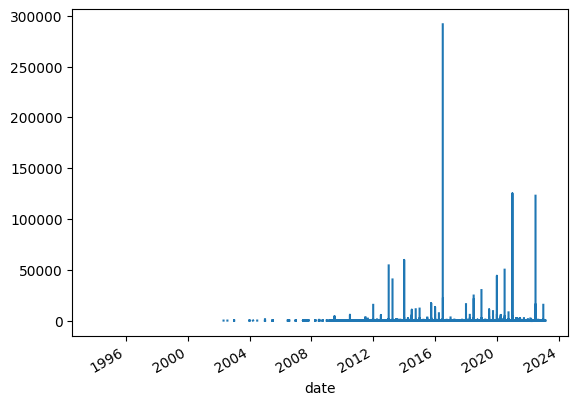

In [179]:
balance_sheet_norm.inventory.plot()

<AxesSubplot:>

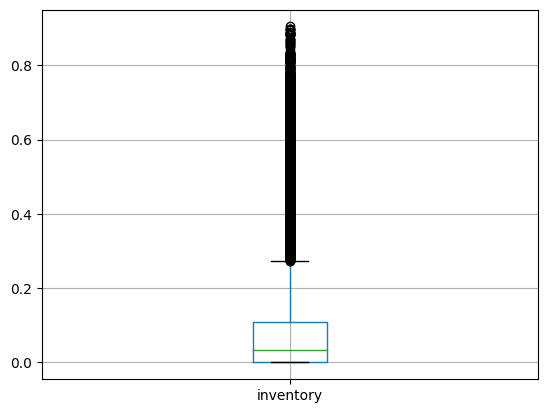

In [114]:
balance_sheet_norm[['inventory']].boxplot()

In [119]:
# Determine missing balance sheet fields

balance_sheet_norm.isnull().sum().sort_values(ascending=False)/len(balance_sheet_norm)

cik                                        0.277821
othertotalStockholdersEquity               0.003127
minorityInterest                           0.000890
capitalLeaseObligations                    0.000890
deferredRevenueNonCurrent                  0.000890
deferredRevenue                            0.000890
totalAssets                                0.000890
otherAssets                                0.000890
taxAssets                                  0.000867
accumulatedOtherComprehensiveIncomeLoss    0.000867
otherNonCurrentLiabilities                 0.000867
taxPayables                                0.000867
otherCurrentLiabilities                    0.000867
shortTermInvestments                       0.000867
otherCurrentAssets                         0.000867
totalLiabilitiesAndTotalEquity             0.000844
totalLiabilitiesAndStockholdersEquity      0.000844
totalLiabilities                           0.000844
otherLiabilities                           0.000844
inventory   

In [120]:
# Use SAIT DNN imputer to impute missing Total Asset values

saits = SAITS(n_steps=48, n_features=33, n_layers=2, d_model=256, d_inner=128, n_head=4, d_k=64, d_v=64, 
              dropout=0.1, epochs=10)

No given device, using default device: cpu
Model initialized successfully. Number of the trainable parameters: 1371446


In [129]:
# Apply XGBImputer

data = balance_sheet_norm

imputer = XGBImputer(with_cv=True)

data_imputed = XGBImputer(with_cv=True).fit_transform(
    data=data,
    missing_values_variable='totalAssets',
    features=['totalLiabilities', 'totalCurrentAssets', 'totalNonCurrentAssets', 'totalCurrentLiabilities'],
    params={'learning_rate':0.3},
    n_jobs=4, # Parallelizing Cross-validation
    n_iter=10 # Random choices among parameters grid
)

TypeError: XGBImputer.fit_transform() got an unexpected keyword argument 'data'

In [117]:
# Robust Scaling 

rb_scaler = RobustScaler() 

rb_scaler.fit(balance_sheet_norm[['inventory']]) 


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [5]:
income_statement=pd.read_csv('raw_data/async_IS.csv')

income_statement

,2023-01-31,A,USD,0001090872,2023,Q2,1756000000,788000000,968000000,0.55125284738041,...,0.23348519362186787,58000000,352000000,0.20045558086560364,1.19,1.19.1,296000000,297000000,https://www.sec.gov/Archives/edgar/data/1090872/000109087223000005/0001090872-23-000005-index.htm,https://www.sec.gov/Archives/edgar/data/1090872/000109087223000005/a-20230131.htm
0,2023-01-31,A,USD,1090872.0,2023,Q1,1.756000e+09,788000000.0,9.680000e+08,0.551253,...,0.233485,58000000.0,352000000.0,0.200456,1.190000,1.190000,2.960000e+08,2.970000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
1,2022-10-31,A,USD,1090872.0,2022,Q4,1.849000e+09,837000000.0,1.012000e+09,0.547323,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2,2022-10-31,A,USD,1090872.0,2023,Q1,1.849000e+09,837000000.0,1.012000e+09,0.547323,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
3,2022-07-31,A,USD,1090872.0,2022,Q3,1.718000e+09,779000000.0,9.390000e+08,0.546566,...,0.231083,68000000.0,329000000.0,0.191502,1.100000,1.100000,2.980000e+08,2.990000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
4,2022-04-30,A,USD,1090872.0,2022,Q2,1.607000e+09,746000000.0,8.610000e+08,0.535781,...,0.207218,59000000.0,274000000.0,0.170504,0.920000,0.910000,2.990000e+08,3.010000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52317,1991-12-31,WBC.AX,AUD,NaN,1992,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,...,0.000000,0.0,-366305480.0,0.000000,-0.206409,-0.206409,1.234180e+09,1.234180e+09,NaN,NaN
52318,1990-12-31,WBC.AX,AUD,NaN,1991,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,...,0.000000,0.0,0.0,0.000000,0.095231,0.095231,1.136867e+09,1.136867e+09,NaN,NaN
52319,1989-12-31,WBC.AX,AUD,NaN,1990,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,...,0.000000,0.0,0.0,0.000000,0.166169,0.166169,1.064317e+09,1.064317e+09,NaN,NaN
52320,1988-12-31,WBC.AX,AUD,NaN,1989,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,...,0.000000,0.0,0.0,0.000000,0.201700,0.201700,1.064317e+09,1.064317e+09,NaN,NaN


In [6]:
income_statement.columns =['date', 'symbol', 'reportedCurrency', 'cik', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
                           'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses', 'generalAndAdministrativeExpenses', 
                           'sellingAndMarketingExpenses', 'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
                           'operatingExpenses', 'costAndExpenses', 'interestIncome', 'interestExpense', 'depreciationAndAmortization', 
                           'ebitda', 'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio', 'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
                           'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome', 'netIncomeRatio', 'eps', 'epsdiluted',
                           'weightedAverageShsOut', 'weightedAverageShsOutDil', 'link', 'finalLink']

income_statement['date']= pd.to_datetime(income_statement['date'])

income_statement.set_index('date', inplace=True)

income_statement

,symbol,reportedCurrency,cik,calendarYear,period,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023,Q1,1.756000e+09,788000000.0,9.680000e+08,0.551253,123000000.0,...,0.233485,58000000.0,352000000.0,0.200456,1.190000,1.190000,2.960000e+08,2.970000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022,Q4,1.849000e+09,837000000.0,1.012000e+09,0.547323,119000000.0,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2023,Q1,1.849000e+09,837000000.0,1.012000e+09,0.547323,119000000.0,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-07-31,A,USD,1090872.0,2022,Q3,1.718000e+09,779000000.0,9.390000e+08,0.546566,116000000.0,...,0.231083,68000000.0,329000000.0,0.191502,1.100000,1.100000,2.980000e+08,2.990000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-04-30,A,USD,1090872.0,2022,Q2,1.607000e+09,746000000.0,8.610000e+08,0.535781,115000000.0,...,0.207218,59000000.0,274000000.0,0.170504,0.920000,0.910000,2.990000e+08,3.010000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-12-31,WBC.AX,AUD,NaN,1992,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,...,0.000000,0.0,-366305480.0,0.000000,-0.206409,-0.206409,1.234180e+09,1.234180e+09,NaN,NaN
1990-12-31,WBC.AX,AUD,NaN,1991,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.095231,0.095231,1.136867e+09,1.136867e+09,NaN,NaN
1989-12-31,WBC.AX,AUD,NaN,1990,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.166169,0.166169,1.064317e+09,1.064317e+09,NaN,NaN


In [99]:
income_statement.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52322 entries, 2023-01-31 to 1988-03-31
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   symbol                                   52322 non-null  object 
 1   reportedCurrency                         52322 non-null  object 
 2   cik                                      37743 non-null  float64
 3   calendarYear                             52322 non-null  int64  
 4   period                                   52321 non-null  object 
 5   revenue                                  52322 non-null  float64
 6   costOfRevenue                            52322 non-null  float64
 7   grossProfit                              52322 non-null  float64
 8   grossProfitRatio                         52322 non-null  float64
 9   researchAndDevelopmentExpenses           52322 non-null  float64
 10  generalAndAdministrativeExpen

In [7]:
cashflow=pd.read_csv('raw_data/async_CF.csv')

cashflow

,2023-01-31,A,USD,0001090872,2023,Q1,352000000,67000000,4000000,44000000,...,-67000000,125000000,-17000000,22000000,197000000,1253000000,1056000000,296000000.1,-76000000.1,220000000
0,2022-10-31,A,USD,1090872.0,2022,Q4,368000000.0,73000000.0,-17000000.0,26000000.0,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,448000000.0,-7.000000e+07,3.780000e+08
1,2022-07-31,A,USD,1090872.0,2022,Q3,329000000.0,80000000.0,6000000.0,28000000.0,...,-62000000.0,992000000.0,-362000000.0,-6000000.0,-115000000.0,1.073000e+09,1.188000e+09,326000000.0,-8.200000e+07,2.440000e+08
2,2022-04-30,A,USD,1090872.0,2022,Q2,274000000.0,82000000.0,-5000000.0,27000000.0,...,-63000000.0,174000000.0,-123000000.0,-12000000.0,72000000.0,1.188000e+09,1.116000e+09,283000000.0,-6.400000e+07,2.190000e+08
3,2022-01-31,A,USD,1090872.0,2022,Q1,283000000.0,82000000.0,24000000.0,44000000.0,...,-63000000.0,204000000.0,-546000000.0,-4000000.0,-374000000.0,1.116000e+09,1.490000e+09,255000000.0,-7.500000e+07,1.800000e+08
4,2021-10-31,A,USD,1090872.0,2021,Q4,442000000.0,84000000.0,-27000000.0,22000000.0,...,-59000000.0,156000000.0,-324000000.0,-3000000.0,55000000.0,1.490000e+09,1.435000e+09,441000000.0,-6.200000e+07,3.790000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44595,1991-01-31,WBC.AX,AUD,NaN,1991,Q1,119176326.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,-4.402573e+07,119176326.5,0.000000e+00,1.191763e+08
44596,1990-09-30,WBC.AX,AUD,NaN,1990,Q4,171231579.0,48049059.5,0.0,0.0,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08
44597,1990-06-30,WBC.AX,AUD,NaN,1990,Q3,171231579.0,48049059.5,0.0,0.0,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08
44598,1990-03-31,WBC.AX,AUD,NaN,1990,Q2,171231579.0,48049059.5,0.0,0.0,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08


In [8]:
cashflow.columns =['date', 'symbol', 'reportedCurrency', 'cik', 'calendarYear', 'period', 'netIncome', 'depreciationAndAmortization',
                   'deferredIncomeTax', 'stockBasedCompensation', 'changeInWorkingCapital', 'accountsReceivables', 'inventory', 'accountsPayables', 'otherWorkingCapital',
                   'otherNonCashItems', 'netCashProvidedByOperatingActivities', 'investmentsInPropertyPlantAndEquipment', 
                    'acquisitionsNet', 'purchasesOfInvestments', 'salesMaturitiesOfInvestments', 'otherInvestingActivites', 'netCashUsedForInvestingActivites', 'debtRepayment',
                    'commonStockIssued', 'commonStockRepurchased', 'dividendsPaid', 'otherFinancingActivites', 'netCashUsedProvidedByFinancingActivities',
                    'effectOfForexChangesOnCash', 'netChangeInCash', 'cashAtEndOfPeriod', 'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure', 'freeCashFlow']

cashflow['date']= pd.to_datetime(cashflow['date'])

cashflow.set_index('date', inplace=True)

cashflow

,symbol,reportedCurrency,cik,calendarYear,period,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,...,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,A,USD,1090872.0,2022,Q4,368000000.0,73000000.0,-17000000.0,26000000.0,-2.000000e+06,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,448000000.0,-7.000000e+07,3.780000e+08
2022-07-31,A,USD,1090872.0,2022,Q3,329000000.0,80000000.0,6000000.0,28000000.0,-1.310000e+08,...,-62000000.0,992000000.0,-362000000.0,-6000000.0,-115000000.0,1.073000e+09,1.188000e+09,326000000.0,-8.200000e+07,2.440000e+08
2022-04-30,A,USD,1090872.0,2022,Q2,274000000.0,82000000.0,-5000000.0,27000000.0,-9.500000e+07,...,-63000000.0,174000000.0,-123000000.0,-12000000.0,72000000.0,1.188000e+09,1.116000e+09,283000000.0,-6.400000e+07,2.190000e+08
2022-01-31,A,USD,1090872.0,2022,Q1,283000000.0,82000000.0,24000000.0,44000000.0,-2.330000e+08,...,-63000000.0,204000000.0,-546000000.0,-4000000.0,-374000000.0,1.116000e+09,1.490000e+09,255000000.0,-7.500000e+07,1.800000e+08
2021-10-31,A,USD,1090872.0,2021,Q4,442000000.0,84000000.0,-27000000.0,22000000.0,1.000000e+07,...,-59000000.0,156000000.0,-324000000.0,-3000000.0,55000000.0,1.490000e+09,1.435000e+09,441000000.0,-6.200000e+07,3.790000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-01-31,WBC.AX,AUD,NaN,1991,Q1,119176326.5,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,-4.402573e+07,119176326.5,0.000000e+00,1.191763e+08
1990-09-30,WBC.AX,AUD,NaN,1990,Q4,171231579.0,48049059.5,0.0,0.0,1.460558e+08,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08
1990-06-30,WBC.AX,AUD,NaN,1990,Q3,171231579.0,48049059.5,0.0,0.0,1.460558e+08,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08


In [100]:
cashflow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44600 entries, 2022-10-31 to 1990-01-31
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   symbol                                    44600 non-null  object 
 1   reportedCurrency                          44600 non-null  object 
 2   cik                                       33066 non-null  float64
 3   calendarYear                              44600 non-null  int64  
 4   period                                    44600 non-null  object 
 5   netIncome                                 44600 non-null  float64
 6   depreciationAndAmortization               44600 non-null  float64
 7   deferredIncomeTax                         44600 non-null  float64
 8   stockBasedCompensation                    44600 non-null  float64
 9   changeInWorkingCapital                    44600 non-null  float64
 10  accountsReceivabl

In [44]:
ratios=pd.read_csv('raw_data/async_ratios.csv')

ratios

,2023-01-31,A,2.106404958677686,1.3992768595041323,0.6456611570247934,303.2659453302961,126.89086294416244,201.66876727218067,61.6751269035533,139.99364036862738,...,25.635353075170844,31.971363636363638,204.61672727272727,152.08,152.08.1,-7.928898181818175,25.635353075170844.1,0.0014883702745354505,93.1009561752988,8.025615974326977.2
0,2022-10-31,A,2.030091,1.320795,0.565825,277.352623,111.612903,180.001221,62.365591,117.635630,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
1,2022-07-31,A,1.940063,1.273396,0.563091,285.753783,116.688062,187.147899,64.467266,122.680633,...,23.144435,30.214392,162.959590,121.969755,121.969755,1.544291,23.144435,0.001559,83.877298,7.810281
2,2022-04-30,A,2.009377,1.348042,0.654164,280.961419,113.042895,182.321054,60.683646,121.637407,...,22.191493,32.538075,162.838950,126.013180,126.013180,-15.292895,22.191493,0.001767,85.735619,6.962462
3,2022-01-31,A,2.193182,1.491793,0.702652,262.738949,103.547120,168.332067,55.955497,112.376569,...,25.050968,37.045336,232.974000,164.452235,164.452235,-1.040119,25.050968,0.001502,103.204550,8.136461
4,2021-10-31,A,2.224239,1.608314,0.868852,257.698795,98.289474,161.831642,52.815789,109.015853,...,28.668181,26.916957,125.565119,107.911973,107.911973,0.396911,28.668181,0.001240,88.307740,8.830800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54313,1990-06-30,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
54314,1990-03-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
54315,1990-01-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,...,0.000000,0.000000,7.934432,6.630100,6.630100,0.000000,0.000000,0.024102,0.000000,0.000000
54316,1988-12-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000


In [45]:
ratios.columns =['date','symbol','currentRatio','quickRatio','cashRatio','daysOfSalesOutstanding',
              'daysOfInventoryOutstanding', 'operatingCycle', 'daysOfPayablesOutstanding','cashConversionCycle',
              'grossProfitMargin', 'operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin', 'effectiveTaxRate', 
             'returnOnAssets', 'returnOnEquity', 'returnOnCapitalEmployed', 'netIncomePerEBT', 'ebtPerEbit', 
             'ebitPerRevenue', 'debtRatio', 'debtEquityRatio', 'longTermDebtToCapitalization', 
             'totalDebtToCapitalization', 'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier', 
             'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover', 'fixedAssetTurnover', 'assetTurnover', 
             'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio', 
             'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio', 'cashFlowCoverageRatios', 
             'shortTermCoverageRatios', 'capitalExpenditureCoverageRatio', 'dividendPaidAndCapexCoverageRatio', 
             'dividendPayoutRatio', 'priceBookValueRatio', 'priceToBookRatio', 'priceToSalesRatio', 
             'priceEarningsRatio', 'priceToFreeCashFlowsRatio', 'priceToOperatingCashFlowsRatio', 'priceCashFlowRatio', 
             'priceEarningsToGrowthRatio', 'priceSalesRatio', 'dividendYield', 'enterpriseValueMultiple', 
             'priceFairValue']

ratios['date']= pd.to_datetime(ratios['date'])

ratios.set_index('date', inplace=True)


In [46]:
ratios

,symbol,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,grossProfitMargin,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,A,2.030091,1.320795,0.565825,277.352623,111.612903,180.001221,62.365591,117.635630,0.547323,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-07-31,A,1.940063,1.273396,0.563091,285.753783,116.688062,187.147899,64.467266,122.680633,0.546566,...,23.144435,30.214392,162.959590,121.969755,121.969755,1.544291,23.144435,0.001559,83.877298,7.810281
2022-04-30,A,2.009377,1.348042,0.654164,280.961419,113.042895,182.321054,60.683646,121.637407,0.535781,...,22.191493,32.538075,162.838950,126.013180,126.013180,-15.292895,22.191493,0.001767,85.735619,6.962462
2022-01-31,A,2.193182,1.491793,0.702652,262.738949,103.547120,168.332067,55.955497,112.376569,0.543608,...,25.050968,37.045336,232.974000,164.452235,164.452235,-1.040119,25.050968,0.001502,103.204550,8.136461
2021-10-31,A,2.224239,1.608314,0.868852,257.698795,98.289474,161.831642,52.815789,109.015853,0.542169,...,28.668181,26.916957,125.565119,107.911973,107.911973,0.396911,28.668181,0.001240,88.307740,8.830800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-06-30,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
1990-03-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
1990-01-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,...,0.000000,0.000000,7.934432,6.630100,6.630100,0.000000,0.000000,0.024102,0.000000,0.000000


In [ ]:
# Determining missing data

.isnull().sum().sort_values(ascending=False)/len(data)

#  Kaggle CDS Data

In [7]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

CDS=pd.read_csv('raw_data/cds.csv')

In [8]:
CDS['Date']= pd.to_datetime(CDS['Date'])

CDS.set_index('Date', inplace=True)

CDS

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-01,A,Agilent Technologies Inc,14.8500,25.0500,39.0550,73.7150,86.3000,111.3050,125.9050,144.3000,158.6000,168.1950
2015-01-02,A,Agilent Technologies Inc,14.8550,25.1500,39.1600,73.6000,86.4000,111.5100,126.1000,144.3750,158.7750,168.3750
2015-01-05,A,Agilent Technologies Inc,13.4550,24.9600,39.3100,70.2000,88.2600,111.9700,125.0600,143.1650,157.3850,166.8250
2015-01-06,A,Agilent Technologies Inc,15.5350,24.8800,39.3000,72.6800,91.1000,116.6100,130.8900,150.3650,165.6550,175.8850
2015-01-07,A,Agilent Technologies Inc,15.2150,25.5000,40.2700,73.8800,92.5000,117.7800,131.9400,151.1450,166.2150,176.2950
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-06,ZIGGO,Ziggo,43.1264,87.0118,129.5117,172.7865,214.8831,266.7008,302.0419,327.0323,345.8258,360.3988
2021-09-07,ZIGGO,Ziggo,43.1224,86.7150,132.9410,176.4412,222.3668,277.1234,313.9639,339.7347,358.9416,373.7222
2021-09-08,ZIGGO,Ziggo,42.3178,86.5418,131.5519,178.4565,223.4681,277.5741,314.0263,339.5492,358.5867,373.2473


In [9]:
CDS.isnull().sum() 

Ticker     0
Company    0
PX1        0
PX2        0
PX3        0
PX4        0
PX5        0
PX6        0
PX7        0
PX8        0
PX9        0
PX10       0
dtype: int64

## SAIT Imputation

In [12]:
saits = SAITS(n_steps=48, n_features=33, n_layers=2, d_model=256, d_inner=128, n_head=4, d_k=64, d_v=64, dropout=0.1, epochs=10)

No given device, using default device: cpu
Model initialized successfully. Number of the trainable parameters: 1371446


In [44]:
saits.fit(preimpute_CF)

AssertionError: input should have 3 dimensions [n_samples, seq_len, n_features],but got shape=torch.Size([44600, 31])

In [13]:
from pypots.data import load_specific_dataset, mcar, masked_fill

data = load_specific_dataset('physionet_2012')

Loading the dataset physionet_2012 with TSDB (https://github.com/WenjieDu/Time_Series_Database)...
Starting preprocessing physionet_2012...
Dataset physionet_2012 has already been downloaded. Processing directly...
Dataset physionet_2012 has already been cached. Loading from cache directly...
Loaded successfully!


In [14]:
data['y']

,In-hospital_death
RecordID,
132592,0
140662,0
140104,0
134685,0
134849,0
...,...
158752,0
157307,0
158034,0


In [15]:
data['X']

,RecordID,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,...,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH
0,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,35.35,NaN,NaN,480.0,NaN,-1.0,NaN
1,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
2,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,NaN,NaN,NaN,170.0,NaN,NaN,NaN
3,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,NaN,37.80,NaN,NaN,60.0,NaN,NaN,NaN
4,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575419,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,...,NaN,NaN,122.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN
575420,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
575421,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,...,NaN,NaN,147.0,37.30,NaN,NaN,50.0,NaN,NaN,NaN
575422,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,...,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Wavelet denoising

In [16]:
from scipy import signal

In [17]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

y = denoise_wavelet(df_ratios['quickRatio'], wavelet='db1', mode='soft', method='VisuShrink', rescale_sigma='True')

pd.DataFrame(y).plot()

NameError: name 'df_ratios' is not defined

In [15]:
y

array([1.56077074, 1.56077074, 1.56077074, 1.56077074, 1.56077074,
       1.56077074, 1.56077074, 1.56077074, 1.43139877, 1.22347215,
       1.30451264, 1.30451264, 1.78536851, 2.43249487, 2.30056249,
       2.30056249, 2.71863015, 2.71863015, 2.71863015, 2.71863015,
       2.71863015, 2.71863015, 2.70093592, 2.73632439, 2.66858293,
       2.66858293, 2.66858293, 2.66858293, 2.82760811, 2.82760811,
       2.80541122, 2.61408205, 2.1882202 , 2.1882202 , 2.1882202 ,
       2.1882202 , 2.0190213 , 2.0190213 , 2.0190213 , 2.0190213 ,
       1.61003886, 2.45685163, 2.26276255, 2.26276255, 2.38031213,
       2.38031213, 2.38863092, 1.44316041, 1.31590959, 1.31590959,
       1.31162709, 2.43992805, 1.65615914, 1.65615914, 1.65615914,
       1.65615914, 1.14541934, 1.14541934, 1.08138958, 1.37052575,
       1.73834071, 1.73834071, 1.79707121, 1.79707121, 1.857428  ,
       1.857428  , 1.95484185, 1.76001415, 1.857428  , 1.857428  ,
       1.857428  , 1.857428  , 1.52752891, 1.52752891, 1.52752

In [25]:
# Check output

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/async_closing_prices.csv')

list


,A,2023-04-28,135.71
0,A,2023-04-27,133.250000
1,A,2023-04-26,133.120000
2,A,2023-04-25,130.370000
3,A,2023-04-24,138.480000
4,A,2023-04-21,138.500000
...,...,...,...
2771761,RELIANCE.NS,1996-01-05,15.658285
2771762,RELIANCE.NS,1996-01-04,15.766594
2771763,RELIANCE.NS,1996-01-03,15.913584
2771764,RELIANCE.NS,1996-01-02,15.793671


# Merge dataframes based on date index and corresponding symbol

In [35]:
df = balance_sheet.merge(ratios, on=['date', 'symbol'])


In [36]:
df

,symbol,reportedCurrency,cik,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-07-31,A,USD,1090872.0,2022-08-31 18:53:26,2022,Q3,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,...,23.144435,30.214392,162.959590,121.969755,121.969755,1.544291,23.144435,0.001559,83.877298,7.810281
2022-04-30,A,USD,1090872.0,2022-05-27 19:33:57,2022,Q2,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,...,22.191493,32.538075,162.838950,126.013180,126.013180,-15.292895,22.191493,0.001767,85.735619,6.962462
2022-01-31,A,USD,1090872.0,2022-03-03 17:02:17,2022,Q1,1.113000e+09,45000000.0,1.158000e+09,1.205000e+09,...,25.050968,37.045336,232.974000,164.452235,164.452235,-1.040119,25.050968,0.001502,103.204550,8.136461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-09-30,WBC.AX,AUD,NaN,1994-09-29 20:00:00,1994,Q4,1.077685e+09,0.0,1.077685e+09,0.000000e+00,...,0.000000,11.214489,10.911149,10.425565,10.425565,-0.126076,0.000000,0.008962,69.949640,1.090883
1993-09-30,WBC.AX,AUD,NaN,1993-09-29 20:00:00,1993,Q4,1.618374e+09,0.0,1.618374e+09,0.000000e+00,...,0.000000,141.565103,23.041102,20.913417,20.913417,0.966107,0.000000,0.009133,1081.217056,0.793319
1992-09-30,WBC.AX,AUD,NaN,1992-09-29 20:00:00,1992,Q4,1.253911e+10,0.0,1.253911e+10,0.000000e+00,...,0.000000,-2.075983,6.380719,6.077426,6.077426,0.030294,0.000000,0.021212,4.953820,0.545912


In [49]:
merged_df = balance_sheet.merge(ratios, on=['date', 'symbol'], how='outer')

In [50]:
merged_df.drop_duplicates()

,symbol,reportedCurrency,cik,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023.0,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-07-31,A,USD,1090872.0,2022-08-31 18:53:26,2022.0,Q3,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,...,23.144435,30.214392,162.959590,121.969755,121.969755,1.544291,23.144435,0.001559,83.877298,7.810281
2022-04-30,A,USD,1090872.0,2022-05-27 19:33:57,2022.0,Q2,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,...,22.191493,32.538075,162.838950,126.013180,126.013180,-15.292895,22.191493,0.001767,85.735619,6.962462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-06-30,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
1991-01-31,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,31.585523,31.585523,31.585523,0.000000,0.000000,0.000000,0.000000,0.000000
1990-06-30,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000


In [51]:
merged_df2 = merged_df.merge(income_statement, on=['date', 'symbol'], how='outer')

In [52]:
merged_df2.drop_duplicates()

,symbol,reportedCurrency_x,cik_x,acceptedDate,calendarYear_x,period_x,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023.0,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,...,0.233485,58000000.0,352000000.0,0.200456,1.190000,1.190000,2.960000e+08,2.970000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993-12-31,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,176732262.0,0.000000,0.909215,0.909215,1.801099e+09,1.801099e+09,NaN,NaN
1992-12-31,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,9735636.0,0.000000,0.002887,0.002887,1.366274e+09,1.366274e+09,NaN,NaN
1991-12-31,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,-366305480.0,0.000000,-0.206409,-0.206409,1.234180e+09,1.234180e+09,NaN,NaN


In [55]:
final_df = merged_df2.merge(cashflow, on=['date', 'symbol'], how='outer')

In [56]:
final_df.drop_duplicates()

,symbol,reportedCurrency_x,cik_x,acceptedDate,calendarYear_x,period_x,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023.0,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,4.480000e+08,-7.000000e+07,378000000.0
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,4.480000e+08,-7.000000e+07,378000000.0
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,4.480000e+08,-7.000000e+07,378000000.0
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,4.480000e+08,-7.000000e+07,378000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-03-31,0019.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-471000000.0,-138000000.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.121750e+09,-5.247500e+08,597000000.0
2001-03-31,0019.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-493250000.0,92250000.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.118750e+09,-3.442500e+08,774500000.0
2000-03-31,0019.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-444250000.0,-519750000.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.185250e+09,-5.235000e+08,661750000.0


# KMV Distance to Default Calculator

In [17]:
# Calculate expected return after 1 year

# Import stock portfolio from excel
df = pd.read_excel("Stock_Portfolio.xlsx")

# Calculate beta for each individual stock
for i in range(len(df)):
    x = df.loc[i, "Stock"]
    ticker = yf.Ticker(x)
    stock_beta = ticker.info["beta"]
    df.at[i, "Beta"]= round(stock_beta,2)
    
    
# find the risk free rate (10 year treasury bill)
treasury_yield10 = yf.Ticker("^TNX") 
risk_free_rate_prem = round(treasury_yield10.info['regularMarketPrice']/100,2)
risk_free_rate_prem

# assume 10 percent return on the return of market ( average return of the S&P 500)
sp500_teturn = 0.10

# Caclulate the portfolio beta
portfolio_beta = round(sum(df["Beta"]* df["stock_weight"]/100),2)
portfolio_beta

# Calculate the expected return of the portfolio
portfolio_exp_return = round(risk_free_rate_prem + portfolio_beta *(sp500_teturn - risk_free_rate_prem),2)

#calulate the expected return for each individual stock using CAPM forumla
df["exp_return"]= round(risk_free_rate_prem + df["Beta"]*(sp500_teturn - risk_free_rate_prem),2)

FileNotFoundError: [Errno 2] No such file or directory: 'Stock_Portfolio.xlsx'

In [10]:
import math
from scipy.stats import norm

def kmv(enterprise_value, short_term_debt, long_term_debt, mu, sigma, period=1):
    """
    KMV Model - https://www.math.ust.hk/~maykwok/Web_ppt/KMV/KMV.pdf
    :param enterprise_value: Enterprise Value of the Firm (can market capitalisation)
    :param short_term_debt: Firm's short term debt
    :param long_term_debt: Firm's long term debt
    :param mu: Expected Return after 1 year
    :param sigma: Expected Annualized Volatility
    :param period: period in years
    :return: EDF (Expected Default Frequency or Probability of Default)
    """

    # Calculate default point
    default_point = short_term_debt + (0.5 * long_term_debt)

    # Numerator
    numer = math.log(enterprise_value / default_point) + (mu - math.pow(sigma, 2) / 2) * period

    # Denominator
    denom = sigma * period

    # Distance to Default
    distance_to_default = numer / denom
    edf = norm.cdf(-distance_to_default)

    return edf

In [11]:
enterprise_value=7.9
short_term_debt=5.0
long_term_debt=5.0
mu=0.1
sigma=0.1

kmv(enterprise_value, short_term_debt, long_term_debt, mu, sigma, period=1)

0.07083541388671619

# XGBoost Imputer

In [20]:
data = pd.DataFrame({
    'F1': [1, 2, 3, 4],
    'F2': [1, 2, 3, np.nan],
    'F3': [3, 2, 3, 4]
})

imputer = XGBImputer(with_cv=True)
imputer.fit(
    data=data,
    missing_values_variable='F2',
    features=['F1', 'F2'],
    params={'learning_rate':0.3},
    n_jobs=4, # Parallelizing Cross-validation
    n_iter=10 # Random choices among parameters grid
)
imputer.transform(data, 'F1')

TypeError: XGBImputer.fit() got an unexpected keyword argument 'data'